In [1]:
''' 

Submitter : JESOON KANG, 20170937
Date : 2019. 10. 


    Assignment 4. 

-   -


'''
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision
import os


In [2]:

#### Section 1. #### This Section is bringed Data_import_ex.py file.

# Image Data import & resize

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=0)  

#### Section 1 END ####


In [3]:

# sigmoid Function.
def sigmoid(z) :
    return 1 / (1 + torch.pow(math.e,-z)+0.000001)

def tanh(z) :
    ret = (2 / (1 + torch.pow(math.e,-2*z) + 0.000001)) - 1
    return ret

def derv_tanh(z) :
    ret = (1 - (tanh(z)**2))
    return ret

def relu(z) :
    ret = z.clone().detach()
    #print(ret)
    tmp = torch.zeros_like(ret)
    ret = torch.where(ret<=0,tmp,ret)
    return ret
                                                                  
def derv_relu(z) :
    ret = z.clone().detach()
    tmp_1 = torch.zeros_like(ret)
    tmp_2 = torch.ones_like(ret)
    ret = torch.where(ret<0,tmp_1,tmp_2)
    #print(ret)
    return ret
    
            
def leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0,ret*0.01,ret)
    return ret

def derv_leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0, tmp1*0.01,tmp1)
    
    return ret

def get_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)
    elif (type == 1) :
        return tanh(z)
    elif (type == 2) :
        return relu(z)
    elif (type == 3) :
        return leakly_relu(z)
    
    else :
        print("Error, get_activation")
        return 0

def get_derv_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)*(1-sigmoid(z))
    elif (type == 1) :
        return derv_tanh(z)
    elif (type == 2) :
        return derv_relu(z)
    elif (type == 3) :
        return derv_leakly_relu(z)    
    else :
        print("Error, get_derv_activation")
        return 0                                                                  

In [22]:
def get_loss(y,a) :
    #print(y,a)
    ret = -(torch.div(y,a+0.000001) - torch.div(1-y,1-a+0.000001))
    
    return ret

BATCH_SIZE = 100
FEATURE_SIZE = 10000
class ML :
    def __init__(self,act1,act2,act3,L1_size,L2_size,L3_size,lr,min_loss_diff) :
        self.act_type_1 = act1
        self.act_type_2 = act2
        self.act_type_3 = act3 
        self.l1_size = L1_size
        self.l2_size = L2_size
        self.l3_size = L3_size
        self.feature_size = 10000
        self.epoch = 0
        self.lr = lr
        self.min_loss_diff = min_loss_diff
        
        self.init_weights()
        
        print("ML Object initialized")
        self.iter = 0

        self.val_acc_log = []
        self.val_loss_log = []
        self.train_acc_log = []
        self.train_loss_log = []
        self.epoch_log = []
        self.val_acc_log.append(0)
        self.val_loss_log.append(0)
        self.train_acc_log.append(0)
        self.train_loss_log.append(0)
        self.epoch_log.append(0)
        
    def init_weights(self) :
        self.w_1 = torch.FloatTensor(self.l1_size,self.feature_size).uniform_(-1,1)
        self.b_1 = torch.FloatTensor(1,self.l1_size).uniform_(-1,1)
        
        #torch.FloatTensor(a, b).uniform_(r1, r2)
        
        self.w_2 = torch.FloatTensor(self.l2_size,self.l1_size).uniform_(-1,1)
        self.b_2 = torch.FloatTensor(1,self.l2_size).uniform_(-1,1)

        self.w_3 = torch.FloatTensor(self.l3_size,self.l2_size).uniform_(-1,1)
        self.b_3 = torch.FloatTensor(1,self.l3_size).uniform_(-1,1)

        

        
    def training(self) :
        
        epoch = 0
        for epoch in range(0,1000000):
            train_acc_log_tmp = []
            train_loss_log_tmp = []
            val_acc_log_tmp = []
            val_loss_log_tmp = []
            

        # load training images of the batch size for every iteration
            for i, data in enumerate(trainloader):
                
                # inputs is the images
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]

                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.t_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.t_data_batch = self.t_data_batch.view(len(data[0]),FEATURE_SIZE)
                self.z_1 = torch.matmul(self.t_data_batch,self.w_1.T) + self.b_1
                #print(self.z_1)
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)
                
                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2

                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                #print(self.z_3)
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1
            
                #print(self.a_3)
                self.t_yh_batch = data[1].float().unsqueeze(1)

                #print(self.a_3,self.t_yh_batch)
                acc = self.get_acc(self.a_3,self.t_yh_batch)
                loss = np.array(get_loss(self.t_yh_batch, self.a_3)).mean()
                
                train_acc_log_tmp.append(acc)
                train_loss_log_tmp.append(loss)
                
                self.update_weights(self.t_yh_batch,self.a_3)
            
            
            
            train_acc = np.array(train_acc_log_tmp).mean()
            train_loss = np.array(train_loss_log_tmp).mean()

            print("epoch : %s, loss : %s, tra_acc : %s"%(epoch,train_loss,train_acc))
            
           

            # load validation images of the batch size for every iteration
            for i, data in enumerate(valloader):

                # inputs is the image
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]
                
                
                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.v_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.v_data_batch = self.v_data_batch.view(len(data[0]),FEATURE_SIZE)
                
                self.z_1 = torch.matmul(self.v_data_batch,self.w_1.T) + self.b_1
                
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)

                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.v_yh_batch = data[1].float().unsqueeze(1)
                acc = self.get_acc(self.a_3,self.v_yh_batch)
                
                
                loss = np.array(get_loss(self.v_yh_batch, self.a_3)).mean()
                val_acc_log_tmp.append(acc)
                val_loss_log_tmp.append(loss)
            val_acc = np.array(val_acc_log_tmp).mean()
            val_loss = np.array(val_loss_log_tmp).mean()
            
            print("epoch : %s, loss : %s, val_acc : %s"%(epoch,val_loss,val_acc))

            self.train_acc_log.append(train_acc)
            self.train_loss_log.append(train_loss)
            self.val_acc_log.append(val_acc)
            self.val_loss_log.append(val_loss)
            self.epoch_log.append(epoch)
            epoch += 1
            
            tmp_idx = len(self.train_loss_log)-1
            if ( abs(self.train_loss_log[tmp_idx]-self.train_loss_log[tmp_idx-1]) < self.min_loss_diff) :
                print("Learning is terminated.")
                break

        
    def update_weights(self,t_y,a_3) :
        error_wb3 = -(torch.div(t_y,a_3+ 0.00011) - torch.div(1.0-t_y,1.0-a_3+ 0.00001)) # sum ep
        d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #         
        d_w_3 = torch.matmul(d_z_3.T,self.a_2)
        d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨
        
        #########
        
        error_wb2 = torch.matmul(d_z_3,self.w_3)
        
        d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)
        
        d_w_2 = torch.matmul(d_z_2.T,self.a_1)
        d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]
        
   
        error_wb1 = torch.matmul(d_z_2,self.w_2)
        d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
        d_w_1 = torch.matmul(d_z_1.T,self.t_data_batch)
        d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]
        
        
        self.w_3 += -self.lr*d_w_3
        self.b_3 += -self.lr*d_b_3
        
        self.w_2 += -self.lr*d_w_2
        self.b_2 += -self.lr*d_b_2
        self.w_1 += -self.lr*d_w_1
        self.b_1 += -self.lr*d_b_1
        #print(b_3,b_2,b_1)
        
    def get_acc(self,yhat,y) :
        count = 0
      
        for a,b in zip(yhat,y) :
            if a >= 0.5 :
                if b == 1 :
                    count+=1
            else :
                if b == 0:
                    count +=1
        
        return count / len(yhat)

    def show_loss(self) :
        #print(self.train_loss_log)
        #print(self.val_loss_log)
        #print(self.epoch_log)
        
        tmp_1 = torch.tensor(self.train_loss_log)
        tmp_2 = torch.tensor(self.epoch_log)
       
        t1 = plt.plot(self.epoch_log,self.train_loss_log, color='orange',label='Training Loss')
        t2 = plt.plot(self.epoch_log,self.val_loss_log, color= 'red',label='Validation Loss')
        plt.title("Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
    def show_acc(self) :
        t1 = plt.plot(self.epoch_log,self.train_acc_log, color='orange',label='Training Acc')
        t2 = plt.plot(self.epoch_log,self.val_acc_log, color= 'red',label='Validation Acc')
        plt.title("Accuracy")
        plt.legend(['Training Acc','Validation Acc'])
        plt.show()



In [33]:

activation_type = 0 # 0 = sigmoid
learningRate = 0.001
min_loss_diff = 0.00001
machine = ML(0,0,0,10,5,1,learningRate,min_loss_diff)





ML Object initialized


In [34]:
machine.training()

epoch : 0, loss : -0.28697488, tra_acc : 0.4873063973063973
epoch : 0, loss : -0.1551614, val_acc : 0.48095238095238096
epoch : 1, loss : -0.15879403, tra_acc : 0.520976430976431
epoch : 1, loss : -0.07721529, val_acc : 0.754047619047619
epoch : 2, loss : -0.12268904, tra_acc : 0.6291582491582491
epoch : 2, loss : 0.07254332, val_acc : 0.7414285714285714
epoch : 3, loss : -0.050587952, tra_acc : 0.6521548821548823
epoch : 3, loss : 0.10511053, val_acc : 0.6523809523809524
epoch : 4, loss : -0.09140489, tra_acc : 0.6372390572390572
epoch : 4, loss : 0.057705294, val_acc : 0.6383333333333333
epoch : 5, loss : -0.039030954, tra_acc : 0.651986531986532
epoch : 5, loss : 0.07785884, val_acc : 0.6416666666666666
epoch : 6, loss : 0.002429182, tra_acc : 0.6512457912457914
epoch : 6, loss : 0.054308306, val_acc : 0.6628571428571429
epoch : 7, loss : -0.028531784, tra_acc : 0.6432323232323233
epoch : 7, loss : 0.039492387, val_acc : 0.6714285714285714
epoch : 8, loss : -0.0012585446, tra_acc : 

epoch : 68, loss : 0.0044244826, tra_acc : 0.755892255892256
epoch : 68, loss : 0.18644764, val_acc : 0.8004761904761905
epoch : 69, loss : -0.049034465, tra_acc : 0.7516161616161617
epoch : 69, loss : 0.20563133, val_acc : 0.8097619047619048
epoch : 70, loss : 0.002483498, tra_acc : 0.7408754208754208
epoch : 70, loss : 0.13992916, val_acc : 0.8190476190476191
epoch : 71, loss : -0.017583298, tra_acc : 0.7613468013468014
epoch : 71, loss : 0.14145648, val_acc : 0.809047619047619
epoch : 72, loss : -0.010340272, tra_acc : 0.7588888888888888
epoch : 72, loss : 0.1076222, val_acc : 0.8130952380952382
epoch : 73, loss : 0.001317371, tra_acc : 0.7643434343434343
epoch : 73, loss : 0.008552118, val_acc : 0.7766666666666667
epoch : 74, loss : -0.03481448, tra_acc : 0.7557912457912458
epoch : 74, loss : 0.17773801, val_acc : 0.8130952380952382
epoch : 75, loss : -0.013510427, tra_acc : 0.7552525252525253
epoch : 75, loss : 0.16397308, val_acc : 0.8033333333333333
epoch : 76, loss : -0.0435008

epoch : 135, loss : -0.03336134, tra_acc : 0.8404377104377104
epoch : 135, loss : -0.16092193, val_acc : 0.809047619047619
epoch : 136, loss : 0.015826415, tra_acc : 0.8437037037037037
epoch : 136, loss : 0.010725875, val_acc : 0.835
epoch : 137, loss : 0.016406028, tra_acc : 0.8453535353535354
epoch : 137, loss : -0.31930983, val_acc : 0.7904761904761904
epoch : 138, loss : 0.006097013, tra_acc : 0.8505387205387205
epoch : 138, loss : -0.032725383, val_acc : 0.8192857142857143
epoch : 139, loss : -0.05455737, tra_acc : 0.8468013468013468
epoch : 139, loss : -0.21972936, val_acc : 0.8099999999999999
epoch : 140, loss : 0.017757308, tra_acc : 0.8538047138047137
epoch : 140, loss : 0.17292227, val_acc : 0.8323809523809523
epoch : 141, loss : 0.003339155, tra_acc : 0.8526262626262627
epoch : 141, loss : 0.29785213, val_acc : 0.8497619047619048
epoch : 142, loss : -0.015673185, tra_acc : 0.8566329966329966
epoch : 142, loss : -0.1364799, val_acc : 0.8245238095238095
epoch : 143, loss : -0.

epoch : 202, loss : 0.061003424, tra_acc : 0.8956228956228955
epoch : 202, loss : 0.1741994, val_acc : 0.8438095238095237
epoch : 203, loss : -0.08498415, tra_acc : 0.9044444444444444
epoch : 203, loss : -0.30961522, val_acc : 0.8104761904761905
epoch : 204, loss : -0.006642805, tra_acc : 0.8932659932659933
epoch : 204, loss : -0.4505014, val_acc : 0.8190476190476191
epoch : 205, loss : -0.018135615, tra_acc : 0.9032659932659932
epoch : 205, loss : -0.07412531, val_acc : 0.8364285714285714
epoch : 206, loss : 0.03618498, tra_acc : 0.9062626262626263
epoch : 206, loss : 0.5490698, val_acc : 0.8423809523809523
epoch : 207, loss : 0.017398102, tra_acc : 0.8980808080808081
epoch : 207, loss : -0.10557651, val_acc : 0.8278571428571428
epoch : 208, loss : -0.024260081, tra_acc : 0.9081818181818182
epoch : 208, loss : -0.57175833, val_acc : 0.8071428571428573
epoch : 209, loss : 0.0012200366, tra_acc : 0.8992592592592593
epoch : 209, loss : -0.55182403, val_acc : 0.8045238095238094
epoch : 21

epoch : 269, loss : -0.1337366, tra_acc : 0.9287205387205386
epoch : 269, loss : -0.50573826, val_acc : 0.8104761904761905
epoch : 270, loss : -0.12101595, tra_acc : 0.9439057239057239
epoch : 270, loss : -0.6290083, val_acc : 0.8183333333333334
epoch : 271, loss : -0.124950595, tra_acc : 0.942087542087542
epoch : 271, loss : -0.4620496, val_acc : 0.8197619047619048
epoch : 272, loss : -0.122609966, tra_acc : 0.9380808080808081
epoch : 272, loss : 0.32011625, val_acc : 0.8304761904761904
epoch : 273, loss : -0.11547344, tra_acc : 0.9414478114478114
epoch : 273, loss : -1.972663, val_acc : 0.7826190476190477
epoch : 274, loss : -0.12590533, tra_acc : 0.9445454545454546
epoch : 274, loss : -0.75043446, val_acc : 0.8138095238095238


KeyboardInterrupt: 

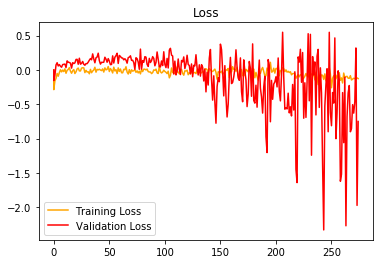

In [35]:
machine.show_loss()

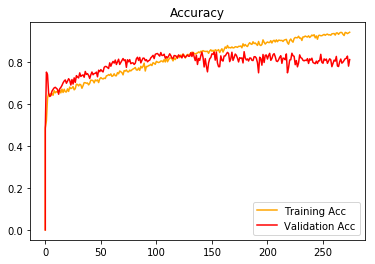

In [36]:
machine.show_acc()